#### Manual testing...

This notebook serves as an integration test to confirm that the model is behaving as we expect.

In [11]:
import sys
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
MODEL_DIR = os.path.realpath(os.path.dirname('..\superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))

In [3]:
from superscript_model import model
from superscript_model.utilities import Random

In [13]:
abm = model.SuperScriptModel(100)

In [14]:
steps = range(10)
active_projects = []
team_size = []

elapsed_times = []

for step in steps:
    
    start_time = time.time()
    abm.step()
    elapsed_time = time.time() - start_time  
    print("Step %d took %.2f seconds" % (step, elapsed_time))
    elapsed_times.append(elapsed_time)
    
    size = 0
    active_projects.append(abm.inventory.active_count)
    
    for project in abm.inventory.projects.values():
        size += len(project.team.members)
    team_size.append(size/len(abm.inventory.projects.values()))

Step 0 took 0.05 seconds
Step 1 took 0.11 seconds
Step 2 took 0.11 seconds
Step 3 took 0.11 seconds
Cannot select 5 workers from bid_pool of size 0 for project 91
Project 91 fails because no team
Cannot select 3 workers from bid_pool of size 0 for project 84
Project 84 fails because no team
Cannot select 3 workers from bid_pool of size 0 for project 86
Project 86 fails because no team
Cannot select 7 workers from bid_pool of size 0 for project 92
Project 92 fails because no team
Cannot select 6 workers from bid_pool of size 0 for project 85
Project 85 fails because no team
Cannot select 5 workers from bid_pool of size 0 for project 96
Project 96 fails because no team
Cannot select 4 workers from bid_pool of size 0 for project 80
Project 80 fails because no team
Cannot select 7 workers from bid_pool of size 0 for project 97
Project 97 fails because no team
Cannot select 4 workers from bid_pool of size 0 for project 83
Project 83 fails because no team
Cannot select 4 workers from bid_poo

In [15]:
print(np.mean(elapsed_times))

0.09948966503143311


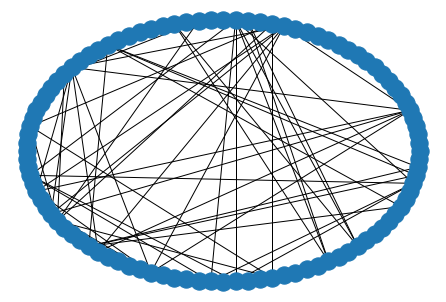

In [20]:
nx.draw(abm.grid.G, pos=nx.circular_layout(abm.grid.G))

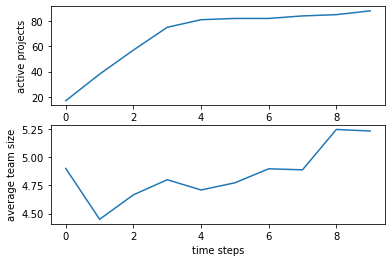

In [7]:
plt.subplot(2,1,1)
plt.plot(steps, active_projects)
plt.ylabel('active projects')

plt.subplot(2,1,2)
plt.plot(steps, team_size)
plt.xlabel('time steps')
plt.ylabel('average team size');

In [8]:
print(np.mean(active_projects[200:]))
print(np.mean(team_size[200:]))

nan
nan


C:\Users\cm1788\Anaconda3\envs\SuperScript\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cm1788\Anaconda3\envs\SuperScript\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### We now select a random worker from the model and inspect the worker:

This produces a json formatted text summary of the worker. Note that this representation will be updated when we add in the worker's history and project activities.

In [9]:
random_worker = Random.choice(abm.schedule.agents)

print(random_worker.skills.to_string())

{
    "Worker OVR": 43.6,
    "Hard skills": [
        2.1,
        2.1,
        2.4,
        2.1,
        2.2
    ],
    "Soft skills": [
        4.8,
        2.9,
        1.7,
        5.0,
        1.4
    ],
    "Hard skill probability": 0.8,
    "OVR multiplier": 20
}


#### We now do the same for a randomly selected project..

In [10]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [11]:
print(random_project.requirements.to_string())

{
    "risk": 25,
    "creativity": 3,
    "flexible_budget": true,
    "max_budget_increase": 0.25,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 7,
    "total_skill_units": 12,
    "hard_skills": {
        "A": {
            "level": null,
            "units": 0
        },
        "B": {
            "level": 1,
            "units": 7
        },
        "C": {
            "level": 4,
            "units": 3
        },
        "D": {
            "level": 5,
            "units": 1
        },
        "E": {
            "level": 5,
            "units": 1
        }
    }
}


#### For this project we can also inspect the Team:

### Note: here the team of 5 is doing its best to meet the high skill unit requirements...Check with Michael. 

In [12]:
print(random_project.team.to_string())

{
    "project": 1960,
    "members": [
        224,
        318,
        943,
        31,
        912
    ],
    "lead": 912,
    "success_probability": 0,
    "team_ovr": 46.3,
    "skill_balance": 5.5,
    "creativity_match": 0.9,
    "skill_contributions": {
        "B": [
            224,
            943,
            318,
            912,
            31
        ],
        "C": [
            318,
            943,
            224
        ],
        "D": [
            224
        ],
        "E": [
            224
        ]
    }
}


#### Note that allocating the total skill units across the skills in a robust way was a non-trivial problem! Solved as follows...

*(Move this to another notebook).*

Select 5 numbers in (1,10) that sum to X, where X <=50
Always a = max(a,1) and b = min(b,10)
-	Select n1 randint(a,b) where a = X – (4\*10) and b = X – (4\*1)
-	Select n2 randint(a,b) where a = X – n1 – (3\*10) and b = X – n1 – (3\*1)
-	Select n3 randint(a,b) where a = X – n1 – n2 – (2\*10) and b = X – n1 – n2 – (2\*1)
-	…
-	Select n5 randint(a,b) where a = X – n1 – n2 – n3 – n4 and b = X – n1 – n2 – n3 – n4


In [13]:
def generate_skills(total):

    min_units = 1
    max_units = 10

    remaining = total
    length = 5

    assert total <= length*max_units
    assert total >= length*min_units

    skills = []

    for i in range(length):

        a = remaining - (length - (i+1))*max_units
        a = max(a, min_units)

        b = remaining - (length - (i+1))*min_units
        b = min(b, max_units)

        n = Random.randint(a,b)
        skills.append(n)
        remaining -= n
        
    assert sum(skills) == total
    return skills

In [14]:
for t in np.arange(5,50):
    print(generate_skills(t), "; sum = ", t)

[1, 1, 1, 1, 1] ; sum =  5
[2, 1, 1, 1, 1] ; sum =  6
[1, 1, 3, 1, 1] ; sum =  7
[4, 1, 1, 1, 1] ; sum =  8
[2, 4, 1, 1, 1] ; sum =  9
[6, 1, 1, 1, 1] ; sum =  10
[3, 5, 1, 1, 1] ; sum =  11
[7, 1, 2, 1, 1] ; sum =  12
[9, 1, 1, 1, 1] ; sum =  13
[7, 3, 1, 2, 1] ; sum =  14
[9, 1, 1, 3, 1] ; sum =  15
[2, 10, 2, 1, 1] ; sum =  16
[3, 10, 2, 1, 1] ; sum =  17
[6, 4, 2, 2, 4] ; sum =  18
[1, 3, 1, 7, 7] ; sum =  19
[10, 6, 2, 1, 1] ; sum =  20
[5, 10, 1, 4, 1] ; sum =  21
[8, 8, 1, 4, 1] ; sum =  22
[9, 10, 1, 2, 1] ; sum =  23
[2, 8, 2, 10, 2] ; sum =  24
[5, 5, 2, 6, 7] ; sum =  25
[10, 1, 9, 2, 4] ; sum =  26
[1, 10, 6, 8, 2] ; sum =  27
[4, 6, 2, 7, 9] ; sum =  28
[10, 7, 1, 2, 9] ; sum =  29
[4, 4, 7, 10, 5] ; sum =  30
[9, 10, 7, 1, 4] ; sum =  31
[4, 2, 6, 10, 10] ; sum =  32
[8, 2, 5, 8, 10] ; sum =  33
[3, 10, 10, 6, 5] ; sum =  34
[4, 2, 10, 10, 9] ; sum =  35
[6, 2, 10, 9, 9] ; sum =  36
[3, 5, 9, 10, 10] ; sum =  37
[8, 2, 9, 10, 9] ; sum =  38
[2, 10, 9, 8, 10] ; sum =  39
[

In [15]:
from itertools import combinations

In [16]:
list(combinations([1], 2))

[]

In [17]:
test = {1:2}

In [18]:
Random.choices([1], 3)

[1, 1, 1]

In [19]:
test = np.int32(1)
t = {test: 1}

In [20]:
np.percentile([1,2,3,4,5], [25,50,75])

array([2., 3., 4.])

In [21]:
test = [True, False, True]

In [22]:
sum(test)

2

In [23]:
1 + True

2

In [24]:
set([1,2]).intersection([1,3,4]).empty

AttributeError: 'set' object has no attribute 'empty'

In [ ]:
t[:2]